In [1]:
import pandas as pd
from bert_score import score
import warnings
warnings.filterwarnings('ignore')

# Leer el archivo de resultados
file_path = "resultados_finales_todos_modelos_final.xlsx"
df = pd.read_excel(file_path)

print(f"✅ Archivo cargado correctamente")
print(f"Total de preguntas: {len(df)}")
print(f"Columnas disponibles: {df.columns.tolist()}")

/Users/s.pineda/Documents/Personal/final_proofs_master_degree/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Archivo cargado correctamente
Total de preguntas: 19
Columnas disponibles: ['Pregunta', 'Respuesta Target', 'Respuesta gpt 3.5 turbo', 'Respuesta gpt 4o', 'Respuesta Gemini 2.0', 'Respuesta Gemini 2.5', 'Respuesta Llama 3.1:8b', 'Respuesta Llama 3.2:1b', 'Respuesta Qwen2.5:1.5b', 'Respuesta Qwen 2.5:7b', 'Respuesta DeepSeek:7b', 'Respuesta DeepSeek:1.5b']


In [2]:
no_info="No se encontró información relevante en"
for col in df.columns:
    for index in df.index:
        answer = str(df.at[index, col])
        question = df.at[index, 'Pregunta']
        if ("ERROR" in answer or no_info in answer):
            print(f"Error encontrado en fila {index}, columna '{col}': {answer, question}")

## Análisis de Métricas Semánticas - BERTScore

Este notebook calcula las métricas de similitud semántica entre las respuestas del modelo target (GPT-5.1) y cada uno de los otros 10 modelos evaluados, utilizando BERTScore.

**Métricas calculadas:**
- **Precision**: Qué tan precisas son las respuestas del modelo comparado con el target
- **Recall**: Qué tan completas son las respuestas del modelo respecto al target
- **F1**: Media armónica entre Precision y Recall

In [3]:
# Definir las columnas de cada modelo (excluyendo el target y la pregunta)
model_columns = [
    'Respuesta gpt 3.5 turbo',
    'Respuesta gpt 4o',
    'Respuesta Gemini 2.0',
    'Respuesta Gemini 2.5',
    'Respuesta Llama 3.1:8b',
    'Respuesta Llama 3.2:1b',
    'Respuesta Qwen2.5:1.5b',
    'Respuesta Qwen 2.5:7b',
    'Respuesta DeepSeek:7b',
    'Respuesta DeepSeek:1.5b'
]

target_column = 'Respuesta Target'

print(f"Modelos a evaluar: {len(model_columns)}")
print("\n".join([f"  - {col}" for col in model_columns]))

Modelos a evaluar: 10
  - Respuesta gpt 3.5 turbo
  - Respuesta gpt 4o
  - Respuesta Gemini 2.0
  - Respuesta Gemini 2.5
  - Respuesta Llama 3.1:8b
  - Respuesta Llama 3.2:1b
  - Respuesta Qwen2.5:1.5b
  - Respuesta Qwen 2.5:7b
  - Respuesta DeepSeek:7b
  - Respuesta DeepSeek:1.5b


In [4]:
# Función para calcular BERTScore entre dos conjuntos de respuestas
def calculate_bertscore(references, candidates, model_name):
    """
    Calcula BERTScore para un conjunto de respuestas
    
    Args:
        references: Lista de respuestas de referencia (target)
        candidates: Lista de respuestas del modelo a evaluar
        model_name: Nombre del modelo para logging
    
    Returns:
        tuple: (precision_avg, recall_avg, f1_avg, precision_list, recall_list, f1_list)
    """
    print(f"\n{'='*60}")
    print(f"Calculando BERTScore para: {model_name}")
    print(f"{'='*60}")
    
    # Filtrar respuestas válidas (no NaN)
    valid_pairs = [(ref, cand) for ref, cand in zip(references, candidates) 
                   if pd.notna(ref) and pd.notna(cand) and str(ref).strip() != '' and str(cand).strip() != '']
    
    if len(valid_pairs) == 0:
        print("⚠️  No hay pares válidos para evaluar")
        return 0, 0, 0, [], [], []
    
    refs = [str(pair[0]) for pair in valid_pairs]
    cands = [str(pair[1]) for pair in valid_pairs]
    
    print(f"Evaluando {len(valid_pairs)} pares de respuestas...")
    
    # Calcular BERTScore (usando modelo multilingüe para español)
    P, R, F1 = score(cands, refs, lang='es', verbose=True, model_type='bert-base-multilingual-cased')
    
    # Convertir a listas de Python
    precision_list = P.tolist()
    recall_list = R.tolist()
    f1_list = F1.tolist()
    
    # Calcular promedios
    precision_avg = sum(precision_list) / len(precision_list)
    recall_avg = sum(recall_list) / len(recall_list)
    f1_avg = sum(f1_list) / len(f1_list)
    
    print(f"✅ Completado")
    print(f"   Precision promedio: {precision_avg:.4f}")
    print(f"   Recall promedio:    {recall_avg:.4f}")
    print(f"   F1 promedio:        {f1_avg:.4f}")
    
    return precision_avg, recall_avg, f1_avg, precision_list, recall_list, f1_list

print("✅ Función calculate_bertscore definida")

✅ Función calculate_bertscore definida


In [5]:
# Extraer respuestas del target
target_responses = df[target_column].tolist()

print(f"Total de respuestas target: {len(target_responses)}")
print(f"Respuestas target válidas: {sum([1 for r in target_responses if pd.notna(r) and str(r).strip() != ''])}")

Total de respuestas target: 19
Respuestas target válidas: 19


In [6]:
# Calcular métricas para cada modelo
results = {}

for model_col in model_columns:
    model_responses = df[model_col].tolist()
    
    # Calcular BERTScore
    p_avg, r_avg, f1_avg, p_list, r_list, f1_list = calculate_bertscore(
        target_responses, 
        model_responses, 
        model_col
    )
    
    # Guardar resultados
    results[model_col] = {
        'precision_avg': p_avg,
        'recall_avg': r_avg,
        'f1_avg': f1_avg,
        'precision_per_question': p_list,
        'recall_per_question': r_list,
        'f1_per_question': f1_list
    }

print("\n" + "="*60)
print("✅ Cálculo de métricas completado para todos los modelos")
print("="*60)


Calculando BERTScore para: Respuesta gpt 3.5 turbo
Evaluando 19 pares de respuestas...
calculating scores...
computing bert embedding.
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 62.88it/s]



done in 1.60 seconds, 11.84 sentences/sec
✅ Completado
   Precision promedio: 0.7624
   Recall promedio:    0.6932
   F1 promedio:        0.7259

Calculando BERTScore para: Respuesta gpt 4o
Evaluando 19 pares de respuestas...
calculating scores...
computing bert embedding.
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 63.35it/s]



done in 1.59 seconds, 11.91 sentences/sec
✅ Completado
   Precision promedio: 0.7723
   Recall promedio:    0.7429
   F1 promedio:        0.7571

Calculando BERTScore para: Respuesta Gemini 2.0
Evaluando 19 pares de respuestas...
calculating scores...
computing bert embedding.
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 75.24it/s]



done in 1.70 seconds, 11.17 sentences/sec
✅ Completado
   Precision promedio: 0.7383
   Recall promedio:    0.6996
   F1 promedio:        0.7176

Calculando BERTScore para: Respuesta Gemini 2.5
Evaluando 19 pares de respuestas...
calculating scores...
computing bert embedding.
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 82.52it/s]



done in 1.62 seconds, 11.72 sentences/sec
✅ Completado
   Precision promedio: 0.7615
   Recall promedio:    0.6785
   F1 promedio:        0.7164

Calculando BERTScore para: Respuesta Llama 3.1:8b
Evaluando 19 pares de respuestas...
calculating scores...
computing bert embedding.
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 81.53it/s]



done in 1.71 seconds, 11.08 sentences/sec
✅ Completado
   Precision promedio: 0.7089
   Recall promedio:    0.6759
   F1 promedio:        0.6918

Calculando BERTScore para: Respuesta Llama 3.2:1b
Evaluando 19 pares de respuestas...
calculating scores...
computing bert embedding.
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 79.30it/s]



done in 1.61 seconds, 11.82 sentences/sec
✅ Completado
   Precision promedio: 0.7116
   Recall promedio:    0.6767
   F1 promedio:        0.6933

Calculando BERTScore para: Respuesta Qwen2.5:1.5b
Evaluando 19 pares de respuestas...
calculating scores...
computing bert embedding.
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 80.83it/s]



done in 1.69 seconds, 11.27 sentences/sec
✅ Completado
   Precision promedio: 0.7301
   Recall promedio:    0.6928
   F1 promedio:        0.7103

Calculando BERTScore para: Respuesta Qwen 2.5:7b
Evaluando 19 pares de respuestas...
calculating scores...
computing bert embedding.
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 80.27it/s]



done in 1.66 seconds, 11.44 sentences/sec
✅ Completado
   Precision promedio: 0.7352
   Recall promedio:    0.7260
   F1 promedio:        0.7304

Calculando BERTScore para: Respuesta DeepSeek:7b
Evaluando 19 pares de respuestas...
calculating scores...
computing bert embedding.
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 82.73it/s]



done in 1.69 seconds, 11.24 sentences/sec
✅ Completado
   Precision promedio: 0.7109
   Recall promedio:    0.7099
   F1 promedio:        0.7102

Calculando BERTScore para: Respuesta DeepSeek:1.5b
Evaluando 19 pares de respuestas...
calculating scores...
computing bert embedding.
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 76.19it/s]

done in 1.69 seconds, 11.22 sentences/sec
✅ Completado
   Precision promedio: 0.7024
   Recall promedio:    0.6881
   F1 promedio:        0.6950

✅ Cálculo de métricas completado para todos los modelos


In [7]:
# Crear DataFrame con resumen de resultados
summary_data = []

for model_col in model_columns:
    summary_data.append({
        'Modelo': model_col.replace('Respuesta ', ''),
        'Precision (Avg)': results[model_col]['precision_avg'],
        'Recall (Avg)': results[model_col]['recall_avg'],
        'F1 (Avg)': results[model_col]['f1_avg']
    })

summary_df = pd.DataFrame(summary_data)

# Ordenar por F1 Score (descendente)
summary_df = summary_df.sort_values('F1 (Avg)', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("RESUMEN DE MÉTRICAS BERTSCORE - Comparación con Target")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


RESUMEN DE MÉTRICAS BERTSCORE - Comparación con Target
       Modelo  Precision (Avg)  Recall (Avg)  F1 (Avg)
       gpt 4o         0.772260      0.742863  0.757127
  Qwen 2.5:7b         0.735249      0.726024  0.730425
gpt 3.5 turbo         0.762440      0.693236  0.725888
   Gemini 2.0         0.738287      0.699579  0.717589
   Gemini 2.5         0.761453      0.678512  0.716354
 Qwen2.5:1.5b         0.730081      0.692828  0.710346
  DeepSeek:7b         0.710907      0.709901  0.710230
DeepSeek:1.5b         0.702431      0.688054  0.694984
 Llama 3.2:1b         0.711648      0.676721  0.693286
 Llama 3.1:8b         0.708948      0.675939  0.691761


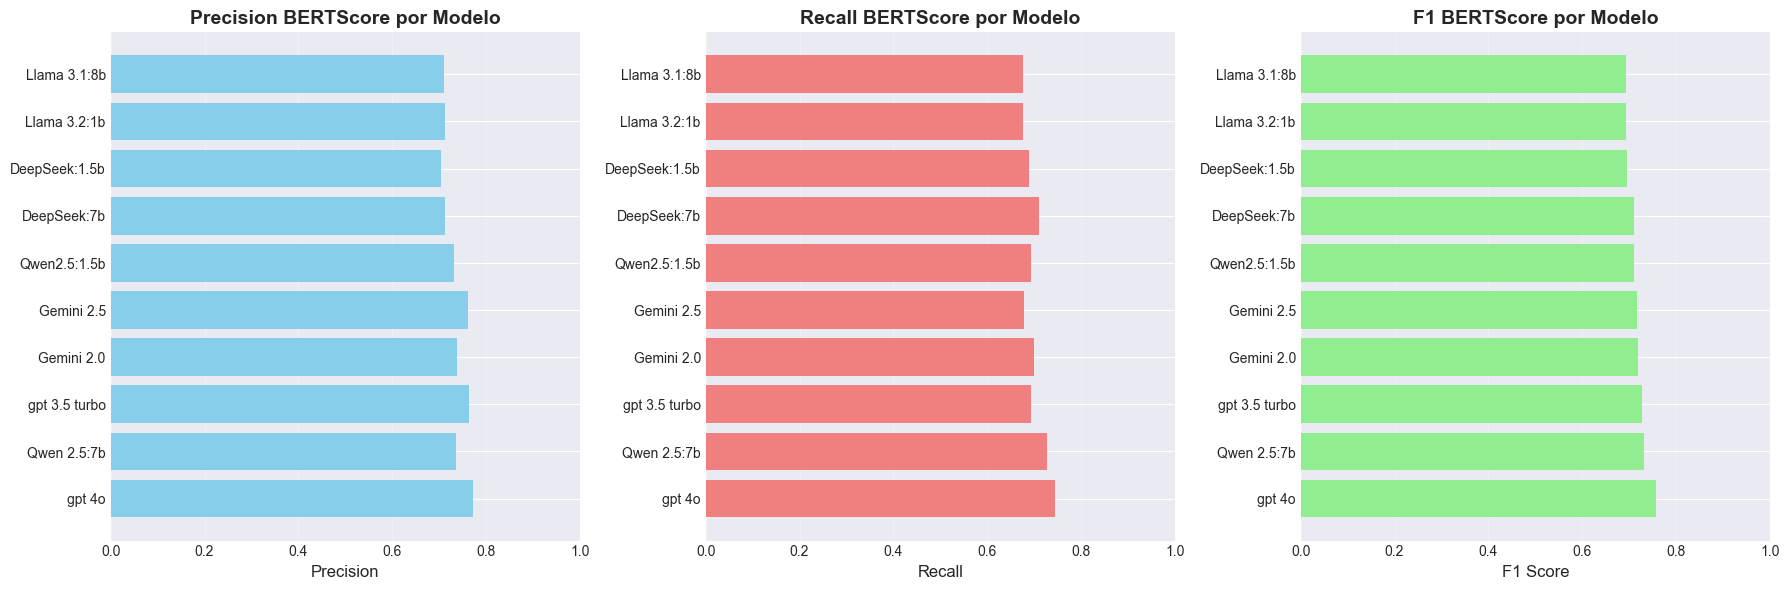

✅ Gráficas guardadas en: bertscore_comparison.png


In [8]:
# Visualización de resultados
import matplotlib.pyplot as plt
import numpy as np

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precisión
axes[0].barh(summary_df['Modelo'], summary_df['Precision (Avg)'], color='skyblue')
axes[0].set_xlabel('Precision', fontsize=12)
axes[0].set_title('Precision BERTScore por Modelo', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
axes[0].grid(axis='x', alpha=0.3)

# Recall
axes[1].barh(summary_df['Modelo'], summary_df['Recall (Avg)'], color='lightcoral')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_title('Recall BERTScore por Modelo', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].grid(axis='x', alpha=0.3)

# F1
axes[2].barh(summary_df['Modelo'], summary_df['F1 (Avg)'], color='lightgreen')
axes[2].set_xlabel('F1 Score', fontsize=12)
axes[2].set_title('F1 BERTScore por Modelo', fontsize=14, fontweight='bold')
axes[2].set_xlim([0, 1])
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('bertscore_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráficas guardadas en: bertscore_comparison.png")

In [9]:
# Crear DataFrame detallado con métricas por pregunta
detailed_results = []

# Obtener el número de preguntas válidas del primer modelo
first_model = model_columns[0]
num_questions = len(results[first_model]['precision_per_question'])

for i in range(num_questions):
    row = {'Pregunta_Index': i + 1}
    
    for model_col in model_columns:
        model_name = model_col.replace('Respuesta ', '')
        row[f'{model_name}_Precision'] = results[model_col]['precision_per_question'][i]
        row[f'{model_name}_Recall'] = results[model_col]['recall_per_question'][i]
        row[f'{model_name}_F1'] = results[model_col]['f1_per_question'][i]
    
    detailed_results.append(row)

detailed_df = pd.DataFrame(detailed_results)

print(f"✅ DataFrame detallado creado con {len(detailed_df)} preguntas")
print(f"Columnas: {len(detailed_df.columns)} (1 index + {len(model_columns)} modelos × 3 métricas)")
print("\nPrimeras 5 filas:")
detailed_df.head()

✅ DataFrame detallado creado con 19 preguntas
Columnas: 31 (1 index + 10 modelos × 3 métricas)

Primeras 5 filas:


,Pregunta_Index,gpt 3.5 turbo_Precision,gpt 3.5 turbo_Recall,gpt 3.5 turbo_F1,gpt 4o_Precision,gpt 4o_Recall,gpt 4o_F1,Gemini 2.0_Precision,Gemini 2.0_Recall,Gemini 2.0_F1,...,Qwen2.5:1.5b_F1,Qwen 2.5:7b_Precision,Qwen 2.5:7b_Recall,Qwen 2.5:7b_F1,DeepSeek:7b_Precision,DeepSeek:7b_Recall,DeepSeek:7b_F1,DeepSeek:1.5b_Precision,DeepSeek:1.5b_Recall,DeepSeek:1.5b_F1
0,1,0.792663,0.758008,0.774948,0.819037,0.802388,0.810627,0.739302,0.715501,0.727207,...,0.726099,0.729707,0.720562,0.725106,0.697996,0.708624,0.703270,0.687053,0.666667,0.676707
1,2,0.758096,0.658887,0.705018,0.805796,0.797472,0.801613,0.670700,0.603785,0.635486,...,0.755850,0.762750,0.739653,0.751024,0.742381,0.720221,0.731133,0.629229,0.610655,0.619803
2,3,0.767218,0.687562,0.725209,0.793588,0.796649,0.795115,0.773352,0.756765,0.764969,...,0.735019,0.749373,0.739505,0.744406,0.746022,0.727192,0.736487,0.717966,0.692875,0.705197
3,4,0.793471,0.704386,0.746279,0.798311,0.746252,0.771404,0.759858,0.726214,0.742655,...,0.730354,0.737072,0.731249,0.734149,0.705109,0.709088,0.707093,0.702473,0.677490,0.689755
4,5,0.756947,0.683513,0.718358,0.773264,0.744108,0.758406,0.790423,0.739207,0.763957,...,0.699569,0.694772,0.691314,0.693039,0.691565,0.702978,0.697225,0.665366,0.670417,0.667882


In [10]:
# Guardar resultados en archivos Excel
# 1. Resumen de métricas promedio
summary_df.to_excel('bertscore_summary.xlsx', index=False)
print("✅ Resumen guardado en: bertscore_summary.xlsx")

# 2. Métricas detalladas por pregunta
detailed_df.to_excel('bertscore_detailed.xlsx', index=False)
print("✅ Métricas detalladas guardadas en: bertscore_detailed.xlsx")

# 3. Crear un archivo Excel con múltiples hojas
with pd.ExcelWriter('bertscore_complete_analysis.xlsx', engine='openpyxl') as writer:
    # Hoja 1: Resumen
    summary_df.to_excel(writer, sheet_name='Resumen', index=False)
    
    # Hoja 2: Métricas por pregunta
    detailed_df.to_excel(writer, sheet_name='Detallado por Pregunta', index=False)
    
    # Hoja 3: Información adicional
    info_df = pd.DataFrame({
        'Descripción': [
            'Total de preguntas evaluadas',
            'Total de modelos evaluados',
            'Modelo con mejor F1',
            'Modelo con mejor Precision',
            'Modelo con mejor Recall',
            'F1 Score máximo',
            'F1 Score mínimo',
            'Modelo con peor F1'
        ],
        'Valor': [
            num_questions,
            len(model_columns),
            summary_df.iloc[0]['Modelo'],
            summary_df.sort_values('Precision (Avg)', ascending=False).iloc[0]['Modelo'],
            summary_df.sort_values('Recall (Avg)', ascending=False).iloc[0]['Modelo'],
            f"{summary_df['F1 (Avg)'].max():.4f}",
            f"{summary_df['F1 (Avg)'].min():.4f}",
            summary_df.iloc[-1]['Modelo']
        ]
    })
    info_df.to_excel(writer, sheet_name='Información General', index=False)

print("✅ Análisis completo guardado en: bertscore_complete_analysis.xlsx")
print("\n" + "="*80)
print("ARCHIVOS GENERADOS:")
print("  1. bertscore_summary.xlsx - Resumen de métricas promedio")
print("  2. bertscore_detailed.xlsx - Métricas por cada pregunta")
print("  3. bertscore_complete_analysis.xlsx - Análisis completo (múltiples hojas)")
print("  4. bertscore_comparison.png - Visualización gráfica")
print("="*80)

✅ Resumen guardado en: bertscore_summary.xlsx
✅ Métricas detalladas guardadas en: bertscore_detailed.xlsx
✅ Análisis completo guardado en: bertscore_complete_analysis.xlsx

ARCHIVOS GENERADOS:
  1. bertscore_summary.xlsx - Resumen de métricas promedio
  2. bertscore_detailed.xlsx - Métricas por cada pregunta
  3. bertscore_complete_analysis.xlsx - Análisis completo (múltiples hojas)
  4. bertscore_comparison.png - Visualización gráfica


## Análisis Estadístico Adicional

Análisis estadístico de las métricas para entender mejor la distribución y variabilidad de los resultados.

In [11]:
# Calcular estadísticas descriptivas para cada modelo
stats_data = []

for model_col in model_columns:
    model_name = model_col.replace('Respuesta ', '')
    
    f1_scores = results[model_col]['f1_per_question']
    precision_scores = results[model_col]['precision_per_question']
    recall_scores = results[model_col]['recall_per_question']
    
    stats_data.append({
        'Modelo': model_name,
        'F1_Media': np.mean(f1_scores),
        'F1_Mediana': np.median(f1_scores),
        'F1_Desv_Std': np.std(f1_scores),
        'F1_Min': np.min(f1_scores),
        'F1_Max': np.max(f1_scores),
        'Precision_Media': np.mean(precision_scores),
        'Precision_Desv_Std': np.std(precision_scores),
        'Recall_Media': np.mean(recall_scores),
        'Recall_Desv_Std': np.std(recall_scores)
    })

stats_df = pd.DataFrame(stats_data)
stats_df = stats_df.sort_values('F1_Media', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("ESTADÍSTICAS DESCRIPTIVAS - BERTScore")
print("="*100)
print(stats_df.to_string(index=False))
print("="*100)

# Guardar estadísticas
stats_df.to_excel('bertscore_statistics.xlsx', index=False)
print("\n✅ Estadísticas guardadas en: bertscore_statistics.xlsx")


ESTADÍSTICAS DESCRIPTIVAS - BERTScore
       Modelo  F1_Media  F1_Mediana  F1_Desv_Std   F1_Min   F1_Max  Precision_Media  Precision_Desv_Std  Recall_Media  Recall_Desv_Std
       gpt 4o  0.757127    0.748331     0.043265 0.675940 0.872604         0.772260            0.038733      0.742863         0.049263
  Qwen 2.5:7b  0.730425    0.729694     0.041537 0.674213 0.881867         0.735249            0.041740      0.726024         0.044235
gpt 3.5 turbo  0.725888    0.718358     0.033583 0.673890 0.825819         0.762440            0.035259      0.693236         0.037915
   Gemini 2.0  0.717589    0.725631     0.054471 0.629545 0.866116         0.738287            0.041506      0.699579         0.070299
   Gemini 2.5  0.716354    0.719966     0.059615 0.628178 0.895119         0.761453            0.049002      0.678512         0.076660
 Qwen2.5:1.5b  0.710346    0.712043     0.058142 0.552692 0.869458         0.730081            0.053204      0.692828         0.067895
  DeepSeek:7b  0

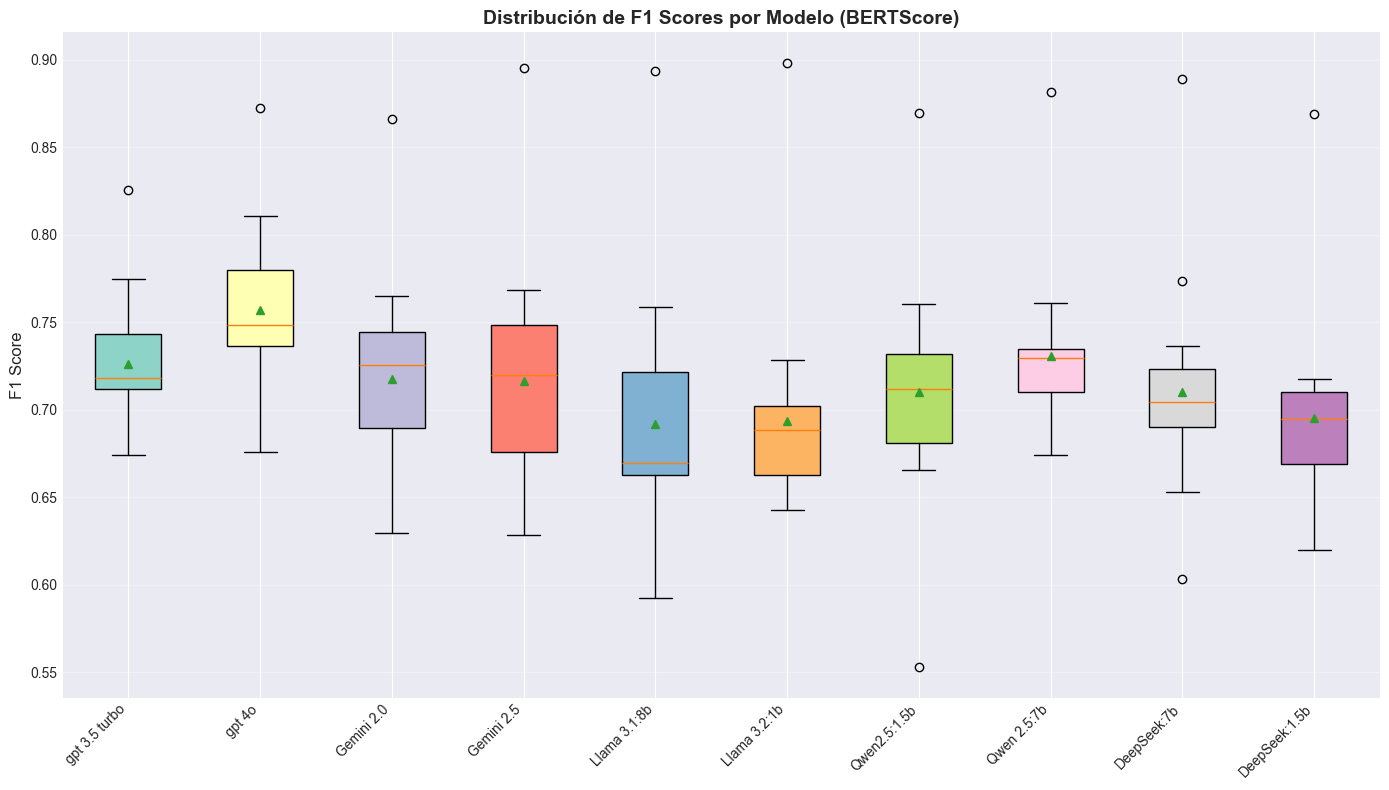

✅ Boxplot guardado en: bertscore_boxplot.png


In [12]:
# Crear boxplot para visualizar distribución de F1 scores
plt.figure(figsize=(14, 8))

# Preparar datos para boxplot
f1_data = []
labels = []

for model_col in model_columns:
    model_name = model_col.replace('Respuesta ', '')
    f1_scores = results[model_col]['f1_per_question']
    f1_data.append(f1_scores)
    labels.append(model_name)

# Crear boxplot
bp = plt.boxplot(f1_data, labels=labels, patch_artist=True, showmeans=True)

# Personalizar colores
colors = plt.cm.Set3(range(len(f1_data)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=45, ha='right')
plt.ylabel('F1 Score', fontsize=12)
plt.title('Distribución de F1 Scores por Modelo (BERTScore)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('bertscore_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Boxplot guardado en: bertscore_boxplot.png")

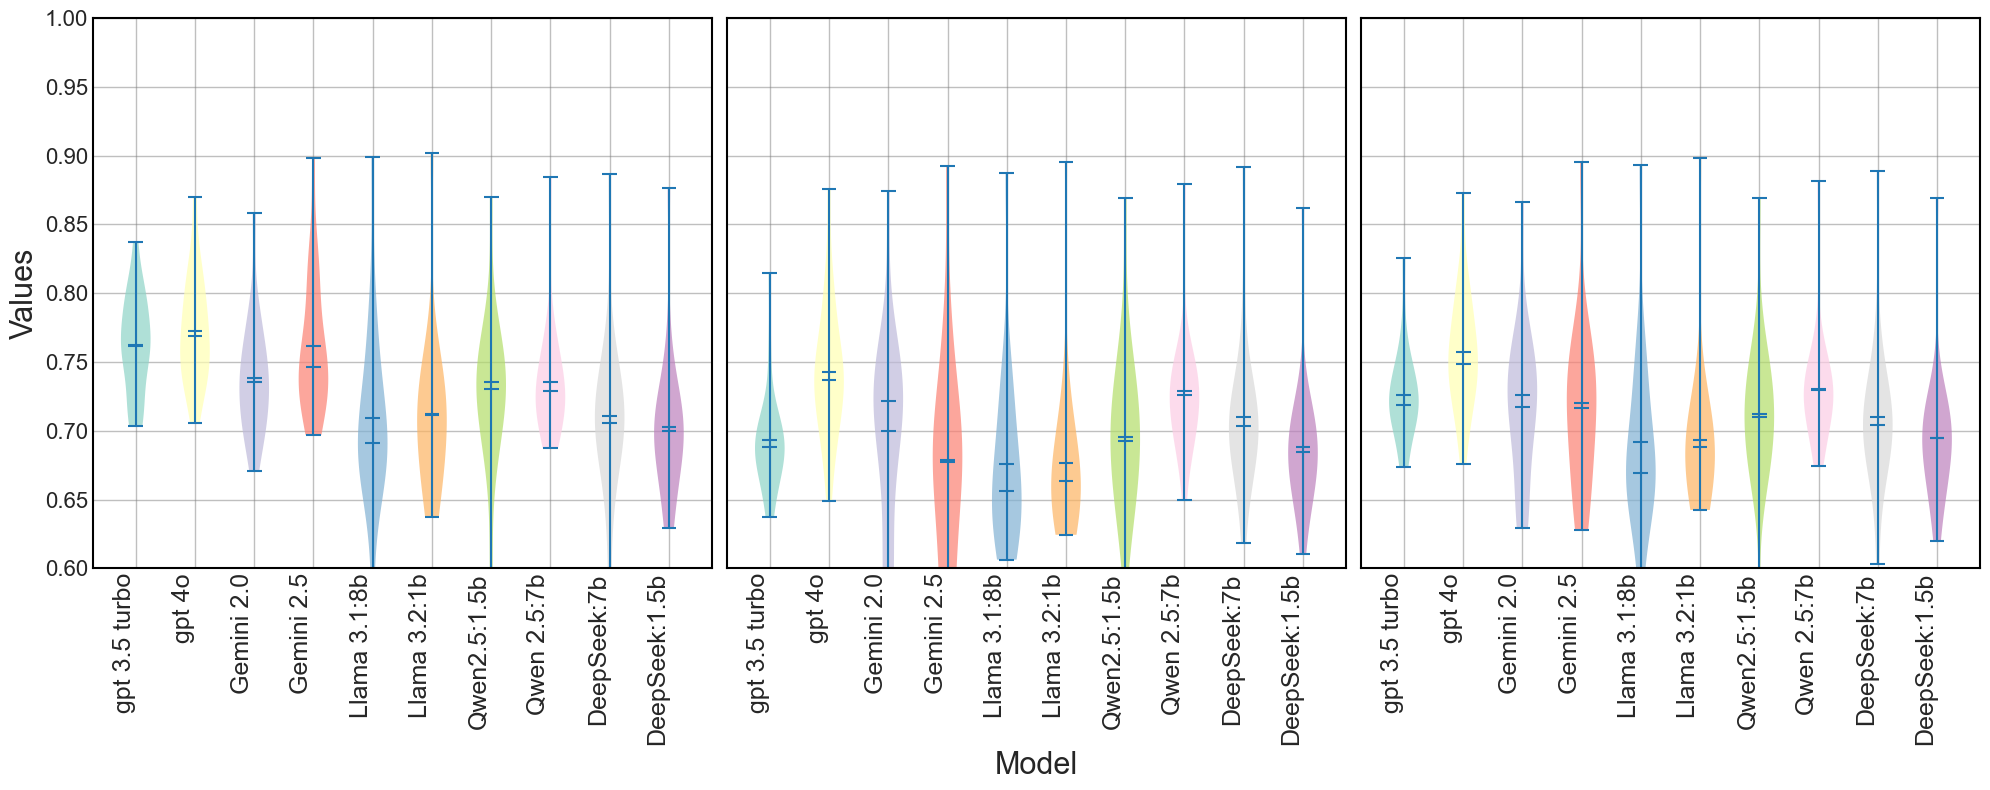

✅ Violin plots guardados en: bertscore_violinplot.pdf


In [14]:
# Crear violin plots para las tres métricas
fig, axes = plt.subplots(1, 3, figsize=(20, 8), facecolor='white')
fig.patch.set_facecolor('white')

# Preparar datos para violin plots
precision_data = []
recall_data = []
f1_data_violin = []
labels_violin = []

for model_col in model_columns:
    model_name = model_col.replace('Respuesta ', '')
    precision_data.append(results[model_col]['precision_per_question'])
    recall_data.append(results[model_col]['recall_per_question'])
    f1_data_violin.append(results[model_col]['f1_per_question'])
    labels_violin.append(model_name)

# Violin plot para Precision
vp1 = axes[0].violinplot(precision_data, positions=range(1, len(labels_violin) + 1), 
                         showmeans=True, showmedians=True)
axes[0].set_xticks(range(1, len(labels_violin) + 1))
axes[0].set_xticklabels(labels_violin, rotation=90, ha='right', fontsize=18)
axes[0].set_ylabel('Values', fontsize=22)
axes[0].tick_params(axis='y', labelsize=16)
axes[0].grid(True, alpha=0.5, linestyle='-', linewidth=1, color='gray')
axes[0].set_ylim([0.6, 1.0])
axes[0].set_facecolor('white')
for spine in axes[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_edgecolor('black')

# Violin plot para Recall
vp2 = axes[1].violinplot(recall_data, positions=range(1, len(labels_violin) + 1), 
                         showmeans=True, showmedians=True)
axes[1].set_xticks(range(1, len(labels_violin) + 1))
axes[1].set_xticklabels(labels_violin, rotation=90, ha='right', fontsize=18)
axes[1].set_xlabel('Model', fontsize=22)
axes[1].set_yticklabels([])
axes[1].tick_params(axis='y', labelsize=16)
axes[1].grid(True, alpha=0.5, linestyle='-', linewidth=1, color='gray')
axes[1].set_ylim([0.6, 1.0])
axes[1].set_facecolor('white')
for spine in axes[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_edgecolor('black')

# Violin plot para F1
vp3 = axes[2].violinplot(f1_data_violin, positions=range(1, len(labels_violin) + 1), 
                         showmeans=True, showmedians=True)
axes[2].set_xticks(range(1, len(labels_violin) + 1))
axes[2].set_xticklabels(labels_violin, rotation=90, ha='right', fontsize=18)
axes[2].set_yticklabels([])
axes[2].tick_params(axis='y', labelsize=16)
axes[2].grid(True, alpha=0.5, linestyle='-', linewidth=1, color='gray')
axes[2].set_ylim([0.6, 1.0])
axes[2].set_facecolor('white')
for spine in axes[2].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_edgecolor('black')

# Personalizar colores de los violin plots
colors = plt.cm.Set3(range(len(precision_data)))
for vp in [vp1, vp2, vp3]:
    for i, pc in enumerate(vp['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)

plt.tight_layout()
plt.savefig('bertscore_violinplot.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Violin plots guardados en: bertscore_violinplot.pdf")

### Interpretación del Análisis de Rendimiento vs Tiempo

**Archivos generados adicionales:**
- `performance_vs_time.xlsx` - Datos combinados de F1 Score y tiempo
- `efficiency_ranking.xlsx` - Ranking de eficiencia (F1/Tiempo)
- `performance_vs_time_scatter.pdf` - Scatter plot de rendimiento vs tiempo
- `performance_comparison_bars.pdf` - Gráficos de barras comparativos

**Métricas clave:**
- **F1 Score**: Calidad de las respuestas (precisión + completitud)
- **Tiempo de Inferencia**: Velocidad de respuesta del modelo
- **Eficiencia (F1/Tiempo)**: Equilibrio óptimo entre calidad y velocidad

**Interpretación del scatter plot:**
- **Zona ideal (arriba-izquierda)**: Alto F1 Score + Bajo tiempo de inferencia
- **Modelos en esta zona**: Ofrecen el mejor equilibrio rendimiento/tiempo
- **Estrella dorada**: Marca el modelo más eficiente globalmente

In [20]:
# Análisis de categorías de modelos
print("\n" + "="*80)
print("ANÁLISIS CATEGÓRICO DE MODELOS")
print("="*80)

# Top 3 en F1 Score
top3_f1 = performance_df.nlargest(3, 'F1 Score')
print("\n🥇 TOP 3 - Mejor F1 Score:")
for idx, row in top3_f1.iterrows():
    print(f"   {row['Modelo']}: F1={row['F1 Score']:.4f}, Tiempo={row['Tiempo Promedio (s)']:.2f}s")

# Top 3 en Velocidad (menor tiempo)
top3_speed = performance_df.nsmallest(3, 'Tiempo Promedio (s)')
print("\n⚡ TOP 3 - Más Rápidos:")
for idx, row in top3_speed.iterrows():
    print(f"   {row['Modelo']}: Tiempo={row['Tiempo Promedio (s)']:.2f}s, F1={row['F1 Score']:.4f}")

# Top 3 en Eficiencia
top3_efficiency = efficiency_df.head(3)
print("\n⚖️  TOP 3 - Mejor Equilibrio (Eficiencia):")
for idx, row in top3_efficiency.iterrows():
    print(f"   {row['Modelo']}: Eficiencia={row['Eficiencia (F1/Tiempo)']:.4f}, F1={row['F1 Score']:.4f}, Tiempo={row['Tiempo Promedio (s)']:.2f}s")

print("\n" + "="*80)


ANÁLISIS CATEGÓRICO DE MODELOS

🥇 TOP 3 - Mejor F1 Score:
   gpt 4o: F1=0.7571, Tiempo=14.76s
   Qwen 2.5:7b: F1=0.7304, Tiempo=14.10s
   gpt 3.5 turbo: F1=0.7259, Tiempo=11.54s

⚡ TOP 3 - Más Rápidos:
   Llama 3.2:1b: Tiempo=9.43s, F1=0.6933
   Gemini 2.0: Tiempo=11.23s, F1=0.7176
   gpt 3.5 turbo: Tiempo=11.54s, F1=0.7259

⚖️  TOP 3 - Mejor Equilibrio (Eficiencia):
   Llama 3.2:1b: Eficiencia=0.0735, F1=0.6933, Tiempo=9.43s
   Gemini 2.0: Eficiencia=0.0639, F1=0.7176, Tiempo=11.23s
   gpt 3.5 turbo: Eficiencia=0.0629, F1=0.7259, Tiempo=11.54s



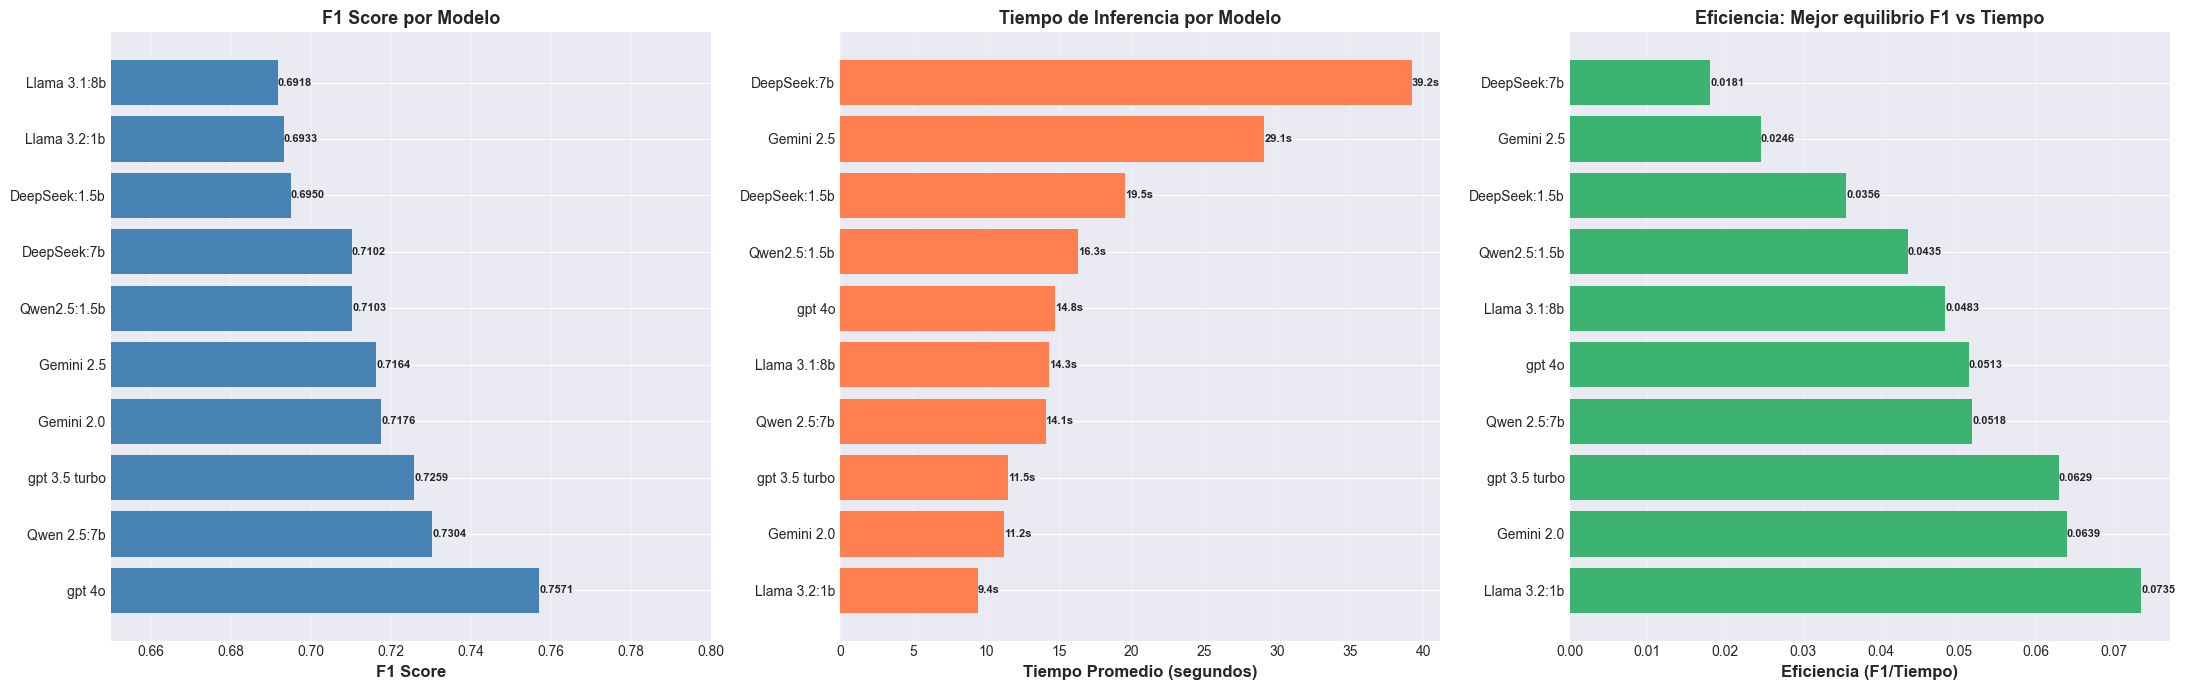

✅ Gráfico comparativo de barras guardado en: performance_comparison_bars.pdf


In [22]:
# Visualización adicional: Gráfico de barras combinado
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

# Ordenar por F1 Score para visualización consistente
sorted_perf_df = performance_df.sort_values('F1 Score', ascending=False)

# Gráfico 1: F1 Score
bars1 = ax1.barh(sorted_perf_df['Modelo'], sorted_perf_df['F1 Score'], color='steelblue')
ax1.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('F1 Score por Modelo', fontsize=13, fontweight='bold')
ax1.set_xlim([0.65, 0.80])
ax1.grid(axis='x', alpha=0.3)
# Añadir valores en las barras
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', 
             ha='left', va='center', fontsize=8, fontweight='bold')

# Gráfico 2: Tiempo de Inferencia (ordenado de menor a mayor)
sorted_by_time = performance_df.sort_values('Tiempo Promedio (s)')
bars2 = ax2.barh(sorted_by_time['Modelo'], sorted_by_time['Tiempo Promedio (s)'], color='coral')
ax2.set_xlabel('Tiempo Promedio (segundos)', fontsize=12, fontweight='bold')
ax2.set_title('Tiempo de Inferencia por Modelo', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
# Añadir valores en las barras
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}s', 
             ha='left', va='center', fontsize=8, fontweight='bold')

# Gráfico 3: Eficiencia (F1/Tiempo)
sorted_by_efficiency = efficiency_df.copy()
bars3 = ax3.barh(sorted_by_efficiency['Modelo'], sorted_by_efficiency['Eficiencia (F1/Tiempo)'], color='mediumseagreen')
ax3.set_xlabel('Eficiencia (F1/Tiempo)', fontsize=12, fontweight='bold')
ax3.set_title('Eficiencia: Mejor equilibrio F1 vs Tiempo', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
# Añadir valores en las barras
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', 
             ha='left', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('performance_comparison_bars.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico comparativo de barras guardado en: performance_comparison_bars.pdf")

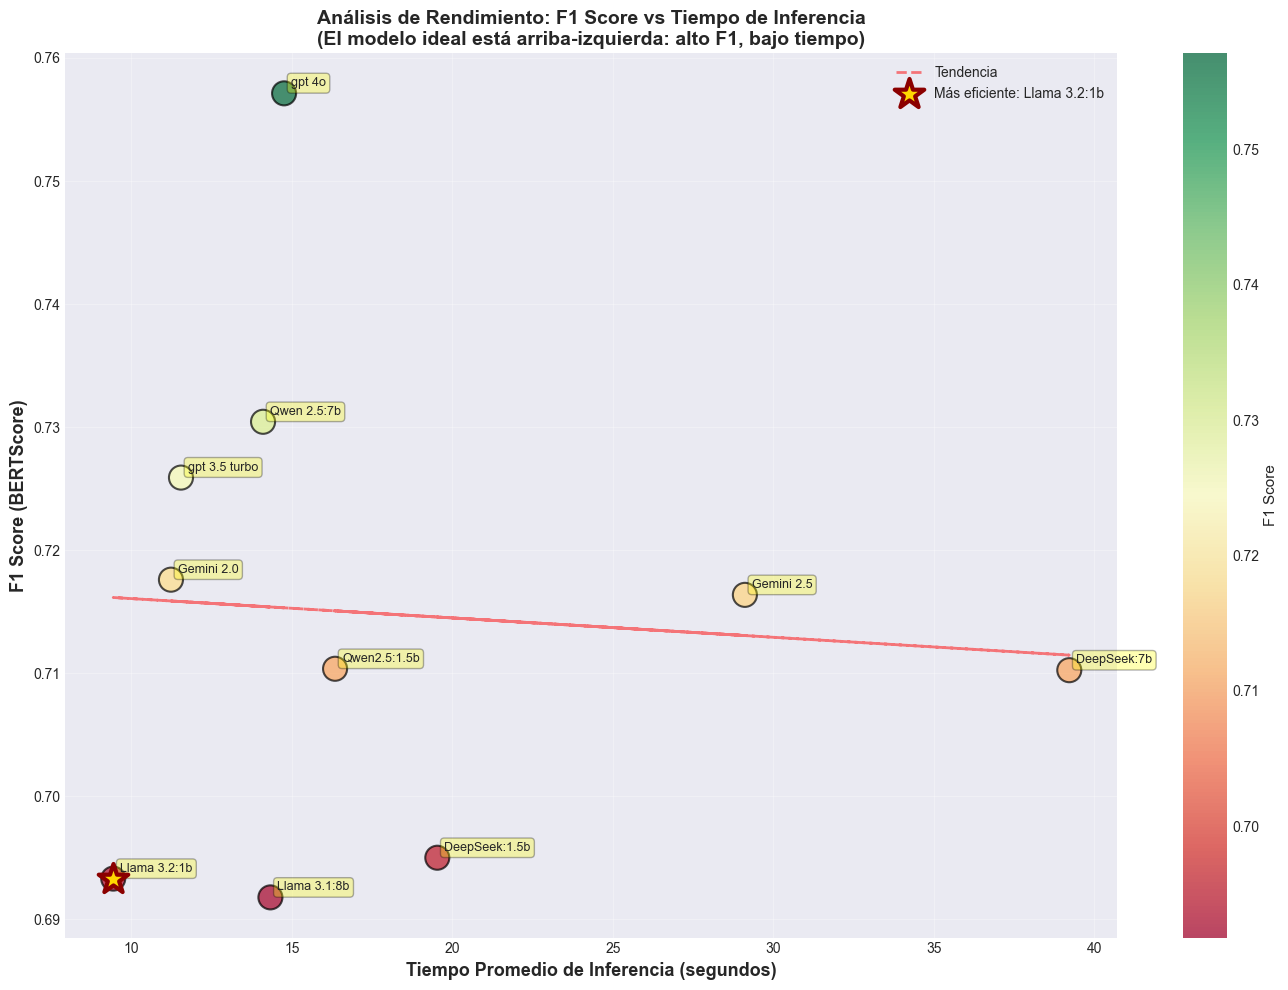

✅ Gráfico de rendimiento vs tiempo guardado en: performance_vs_time_scatter.pdf


In [21]:
# Visualización: Scatter plot F1 Score vs Tiempo de Inferencia
fig, ax = plt.subplots(figsize=(14, 10))

# Crear scatter plot
scatter = ax.scatter(performance_df['Tiempo Promedio (s)'], 
                     performance_df['F1 Score'],
                     s=300, 
                     c=performance_df['F1 Score'],
                     cmap='RdYlGn',
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=1.5)

# Añadir etiquetas para cada punto
for idx, row in performance_df.iterrows():
    ax.annotate(row['Modelo'], 
                (row['Tiempo Promedio (s)'], row['F1 Score']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Añadir línea de tendencia
z = np.polyfit(performance_df['Tiempo Promedio (s)'], performance_df['F1 Score'], 1)
p = np.poly1d(z)
ax.plot(performance_df['Tiempo Promedio (s)'], 
        p(performance_df['Tiempo Promedio (s)']), 
        "r--", 
        alpha=0.5, 
        linewidth=2,
        label='Tendencia')

# Identificar el modelo más eficiente
best_model = efficiency_df.iloc[0]
ax.scatter(best_model['Tiempo Promedio (s)'], 
          best_model['F1 Score'],
          s=500, 
          marker='*',
          c='gold',
          edgecolors='darkred',
          linewidth=3,
          zorder=5,
          label=f'Más eficiente: {best_model["Modelo"]}')

ax.set_xlabel('Tiempo Promedio de Inferencia (segundos)', fontsize=13, fontweight='bold')
ax.set_ylabel('F1 Score (BERTScore)', fontsize=13, fontweight='bold')
ax.set_title('Análisis de Rendimiento: F1 Score vs Tiempo de Inferencia\n(El modelo ideal está arriba-izquierda: alto F1, bajo tiempo)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Añadir colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('F1 Score', fontsize=11)

plt.tight_layout()
plt.savefig('performance_vs_time_scatter.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico de rendimiento vs tiempo guardado en: performance_vs_time_scatter.pdf")

In [19]:
# Calcular métrica de eficiencia: F1 Score / Tiempo
performance_df['Eficiencia (F1/Tiempo)'] = performance_df['F1 Score'] / performance_df['Tiempo Promedio (s)']

# Ordenar por eficiencia
efficiency_df = performance_df.sort_values('Eficiencia (F1/Tiempo)', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("RANKING DE EFICIENCIA - Mejor equilibrio entre F1 Score y Tiempo")
print("="*80)
print(efficiency_df[['Modelo', 'F1 Score', 'Tiempo Promedio (s)', 'Eficiencia (F1/Tiempo)']].to_string(index=False))
print("="*80)

print(f"\n🏆 MODELO MÁS EFICIENTE: {efficiency_df.iloc[0]['Modelo']}")
print(f"   F1 Score: {efficiency_df.iloc[0]['F1 Score']:.4f}")
print(f"   Tiempo: {efficiency_df.iloc[0]['Tiempo Promedio (s)']:.2f}s")
print(f"   Eficiencia: {efficiency_df.iloc[0]['Eficiencia (F1/Tiempo)']:.4f}")

# Guardar ranking de eficiencia
efficiency_df.to_excel('efficiency_ranking.xlsx', index=False)
print("\n✅ Ranking de eficiencia guardado en: efficiency_ranking.xlsx")


RANKING DE EFICIENCIA - Mejor equilibrio entre F1 Score y Tiempo
       Modelo  F1 Score  Tiempo Promedio (s)  Eficiencia (F1/Tiempo)
 Llama 3.2:1b  0.693286             9.432105                0.073503
   Gemini 2.0  0.717589            11.231053                0.063893
gpt 3.5 turbo  0.725888            11.543684                0.062882
  Qwen 2.5:7b  0.730425            14.100526                0.051801
       gpt 4o  0.757127            14.755789                0.051310
 Llama 3.1:8b  0.691761            14.330000                0.048274
 Qwen2.5:1.5b  0.710346            16.344737                0.043460
DeepSeek:1.5b  0.694984            19.530000                0.035585
   Gemini 2.5  0.716354            29.114211                0.024605
  DeepSeek:7b  0.710230            39.222105                0.018108

🏆 MODELO MÁS EFICIENTE: Llama 3.2:1b
   F1 Score: 0.6933
   Tiempo: 9.43s
   Eficiencia: 0.0735

✅ Ranking de eficiencia guardado en: efficiency_ranking.xlsx


In [18]:
# Crear DataFrame combinado con F1 Score y Tiempo de Inferencia
performance_data = []

for index, row in summary_df.iterrows():
    model_name = row['Modelo']
    f1_score = row['F1 (Avg)']
    
    # Buscar el tiempo promedio correspondiente
    if model_name in avg_times:
        avg_time = avg_times[model_name]
        
        performance_data.append({
            'Modelo': model_name,
            'F1 Score': f1_score,
            'Tiempo Promedio (s)': avg_time,
            'Precision': row['Precision (Avg)'],
            'Recall': row['Recall (Avg)']
        })

performance_df = pd.DataFrame(performance_data)

print("\n" + "="*80)
print("ANÁLISIS DE RENDIMIENTO - F1 Score vs Tiempo de Inferencia")
print("="*80)
print(performance_df.to_string(index=False))
print("="*80)

# Guardar resultados
performance_df.to_excel('performance_vs_time.xlsx', index=False)
print("\n✅ Datos de rendimiento guardados en: performance_vs_time.xlsx")


ANÁLISIS DE RENDIMIENTO - F1 Score vs Tiempo de Inferencia
       Modelo  F1 Score  Tiempo Promedio (s)  Precision   Recall
       gpt 4o  0.757127            14.755789   0.772260 0.742863
  Qwen 2.5:7b  0.730425            14.100526   0.735249 0.726024
gpt 3.5 turbo  0.725888            11.543684   0.762440 0.693236
   Gemini 2.0  0.717589            11.231053   0.738287 0.699579
   Gemini 2.5  0.716354            29.114211   0.761453 0.678512
 Qwen2.5:1.5b  0.710346            16.344737   0.730081 0.692828
  DeepSeek:7b  0.710230            39.222105   0.710907 0.709901
DeepSeek:1.5b  0.694984            19.530000   0.702431 0.688054
 Llama 3.2:1b  0.693286             9.432105   0.711648 0.676721
 Llama 3.1:8b  0.691761            14.330000   0.708948 0.675939

✅ Datos de rendimiento guardados en: performance_vs_time.xlsx


In [17]:
# Mapeo de columnas de tiempo a nombres de modelos
time_column_mapping = {
    'Tiempo Inferencia gpt 3.5 turbo': 'gpt 3.5 turbo',
    'Tiempo Inferencia gpt 4o': 'gpt 4o',
    'Tiempo Inferencia Gemini 2.0': 'Gemini 2.0',
    'Tiempo Inferencia Gemini 2.5': 'Gemini 2.5',
    'Tiempo inferencia Llama 3.1:8b': 'Llama 3.1:8b',
    'Tiempo Inferencia Llama 3.2:1b': 'Llama 3.2:1b',
    'Tiempo Inferencia Qwen2.5:1.5b': 'Qwen2.5:1.5b',
    'Tiempo Inferencia Qwen2.5:7b': 'Qwen 2.5:7b',
    'Tiempo Inferencia DeepSeek:7b': 'DeepSeek:7b',
    'Tiempo Inferencia DeepSeek:1.5b': 'DeepSeek:1.5b'
}

# Calcular tiempos promedio para cada modelo
avg_times = {}
for time_col, model_name in time_column_mapping.items():
    if time_col in time_df.columns:
        avg_time = time_df[time_col].mean()
        avg_times[model_name] = avg_time
        print(f"{model_name}: {avg_time:.2f} segundos (promedio)")
    else:
        print(f"⚠️  Columna '{time_col}' no encontrada")

print(f"\n✅ Tiempos promedio calculados para {len(avg_times)} modelos")

gpt 3.5 turbo: 11.54 segundos (promedio)
gpt 4o: 14.76 segundos (promedio)
Gemini 2.0: 11.23 segundos (promedio)
Gemini 2.5: 29.11 segundos (promedio)
Llama 3.1:8b: 14.33 segundos (promedio)
Llama 3.2:1b: 9.43 segundos (promedio)
Qwen2.5:1.5b: 16.34 segundos (promedio)
Qwen 2.5:7b: 14.10 segundos (promedio)
DeepSeek:7b: 39.22 segundos (promedio)
DeepSeek:1.5b: 19.53 segundos (promedio)

✅ Tiempos promedio calculados para 10 modelos


In [16]:
# Cargar datos de tiempo de inferencia
time_file_path = "bitacora_chatbot_recomendación_wo_think.xlsx"
time_df = pd.read_excel(time_file_path)

print(f"✅ Archivo de tiempos cargado correctamente")
print(f"Total de registros: {len(time_df)}")
print(f"Columnas de tiempo disponibles: {time_df.columns.tolist()}")

✅ Archivo de tiempos cargado correctamente
Total de registros: 19
Columnas de tiempo disponibles: ['Pregunta', 'Respuesta Target', 'Respuesta gpt 3.5 turbo', 'Respuesta gpt 4o', 'Respuesta Gemini 2.0', 'Respuesta Gemini 2.5', 'Respuesta Llama 3.1:8b', 'Respuesta Llama 3.2:1b', 'Respuesta Qwen2.5:1.5b', 'Respuesta Qwen 2.5:7b', 'Respuesta DeepSeek:7b', 'Respuesta DeepSeek:1.5b', 'Tiempo Inferencia gpt 3.5 turbo', 'Tiempo Inferencia gpt 4o', 'Tiempo Inferencia Gemini 2.0', 'Tiempo Inferencia Gemini 2.5', 'Tiempo inferencia Llama 3.1:8b', 'Tiempo Inferencia Llama 3.2:1b', 'Tiempo Inferencia Qwen2.5:1.5b', 'Tiempo Inferencia Qwen2.5:7b', 'Tiempo Inferencia DeepSeek:7b', 'Tiempo Inferencia DeepSeek:1.5b']


## Análisis de Rendimiento vs Tiempo de Inferencia

Análisis del equilibrio entre la calidad de las respuestas (F1 Score) y el tiempo de inferencia para identificar el modelo óptimo.

## Resumen Final

Este análisis ha calculado las métricas BERTScore para comparar las respuestas de 10 modelos diferentes contra el modelo target (GPT-5.1).

**Archivos generados:**
1. `bertscore_summary.xlsx` - Métricas promedio por modelo
2. `bertscore_detailed.xlsx` - Métricas detalladas por cada pregunta
3. `bertscore_complete_analysis.xlsx` - Análisis completo con múltiples hojas
4. `bertscore_statistics.xlsx` - Estadísticas descriptivas
5. `bertscore_comparison.png` - Gráficas comparativas
6. `bertscore_boxplot.png` - Distribución de F1 scores

**Interpretación de las métricas:**
- **Precision**: Qué tan relevantes son las respuestas del modelo evaluado
- **Recall**: Qué tan completas son las respuestas comparadas con el target
- **F1**: Balance entre precision y recall (media armónica)

## Conclusiones del Análisis BERTScore

### Resultados Obtenidos

| Métrica | Modelo | Valor |
|---------|--------|-------|
| **Mayor F1-Score** (Mejor respuesta según normativa) | **GPT-4o** | **0.7571** |
| **Menor Recall** (Mayor omisión de información) | **Llama 3.1:8b** | **0.6759** |
| **Menor Precision** (Mayor invención de información) | **DeepSeek:1.5b** | **0.7024** |

### Interpretación

1. **GPT-4o como modelo óptimo**: Con un F1-Score de 0.7571, GPT-4o demuestra el mejor balance entre precisión y completitud, siendo el modelo que mejor responde acorde a las normativas eléctricas. Su combinación de alta precisión (0.7723) y recall (0.7429) lo posiciona como la mejor alternativa al target.

2. **Llama 3.1:8b y la omisión de información**: Con el recall más bajo (0.6759), este modelo tiende a generar respuestas incompletas, omitiendo información relevante presente en el target. Esto puede ser problemático en consultas técnicas donde la completitud es crítica.

3. **DeepSeek:1.5b y la invención de información**: Su baja precisión (0.7024) sugiere que este modelo incluye información no presente en el target o diverge más en su generación. Esto podría implicar menor adherencia a la información recuperada o mayor "creatividad" en las respuestas.

### Observación Importante

**Todos los modelos muestran métricas relativamente cercanas** (F1 entre 0.69-0.76), lo cual sugiere que:

- **El componente de recuperación (RAG) es idéntico para todos**: Todos los modelos reciben el mismo contexto de las bases de datos vectoriales, por lo que las diferencias observadas se deben principalmente a la **capacidad generativa** de cada LLM.

- **Las diferencias son moderadas pero significativas**: Aunque parezcan pequeñas, en aplicaciones técnicas como normativas eléctricas, una diferencia del 6-7% en F1-Score puede traducirse en respuestas notablemente más precisas o completas.

- **El sistema RAG es robusto**: La similitud general entre modelos indica que el sistema de recuperación proporciona contexto adecuado, y las variaciones dependen de cómo cada modelo interpreta y sintetiza esa información.

### Recomendación

Para aplicaciones en normativa eléctrica colombiana donde la precisión técnica es crítica, **GPT-4o** representa la mejor opción, seguido de **Qwen 2.5:7b** como alternativa open-source competitiva (F1: 0.7304).